<a href="https://colab.research.google.com/github/Ruqyai/MENADD-DL/blob/main/GAN/Implementing_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Steps to Implement Basic GAN
1. Importing all libraries
2. Getting the Dataset
3. Data Preparation – It includes various steps to accomplish like preprocessing data, scaling, flattening, and reshaping the data.
4. Define the function Generator and Discriminator.
5. Create a Random Noise and then create an Image with Random Noise.
6. Setting Parameters like defining epoch, batch size, and Sample size.
7. Define the function of generating Sample Images.
8. Train Discriminator then trains Generator and it will create Images.
9. Will see what clarity of Images is created by Generator.

##Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

## Loading MNIST Dataset

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Scale the inputs in range of (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

11501568/11490434 [==============================] - 0s 0us/step


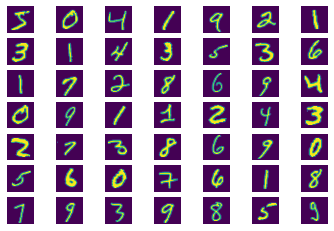

In [4]:

# Plot some example images
for i in range(49):
  plt.subplot(7, 7, i+1)
  plt.axis("off")
  #plot raw pixel data
  plt.imshow(x_train[i])
plt.show()

## Flattening and Scaling the data

In [5]:
N, H, W = x_train.shape  #number, height, width
D = H * W   #dimension (28, 28)
x_train = x_train.reshape(-1, D) 
x_test = x_test.reshape(-1, D)

## Defining Generator Model

In [6]:
# Defining Generator Model
latent_dim = 100 #latent dimension is a variable that defines the number of inputs to the model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)  #because Image pixel is between -1 to 1.
  model = Model(i, x)  #i is input x is output layer
  return model

## Defining Discriminator Model

In [7]:
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

## Compile Models

In [8]:
# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile ( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
# Build and compile the combined model
generator = build_generator(latent_dim)

##Represent Noise Sample

In [9]:
## Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))
## Pass noise through a generator to get an Image
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)

##Create Generator Model

In [10]:
combined_model_gen = Model(z, fake_pred)  #first is noise and 2nd is fake prediction
# Compile the combined model
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

##Defining Parameters for the training of GAN

In [11]:
batch_size = 32
epochs = 1200
sample_period = 200
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)
#store generator and discriminator loss in each step or each epoch
d_losses = []
g_losses = []
#create a file in which generator will create and save images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

##Function to create Sample Images

In [12]:
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)
  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5
  fig, axs = plt.subplots(rows, cols)  #fig to plot img and axis to store
  idx = 0
  for i in range(rows):  #5*5 loop means on page 25 imgs will be there
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

## Train Discriminator and then Generator to generate Images

In [13]:
#FIRST we will train Discriminator(with real imgs and fake imgs)
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]  #MNIST dataset
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)  #generator to generate fake imgs
  fake_imgs = generator.predict(noise)
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)  #belong to positive class(real imgs)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)  #fake imgs
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  #######################
  ### Train generator ###
  #######################
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)  
  #Now we are trying to fool the discriminator that generate imgs are real that's why we are providing label as 1
  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
  # Save the losses
  d_losses.append(d_loss)  #save the loss at each epoch
  g_losses.append(g_loss)
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  if epoch % sample_period == 0:
    sample_images(epoch)

epoch: 1/1200, d_loss: 0.80, d_acc: 0.41, g_loss: 0.98
epoch: 101/1200, d_loss: 0.03, d_acc: 1.00, g_loss: 3.78
epoch: 201/1200, d_loss: 0.55, d_acc: 0.58, g_loss: 1.15
epoch: 301/1200, d_loss: 0.72, d_acc: 0.47, g_loss: 0.59
epoch: 401/1200, d_loss: 0.70, d_acc: 0.47, g_loss: 0.63
epoch: 501/1200, d_loss: 0.69, d_acc: 0.50, g_loss: 0.65
epoch: 601/1200, d_loss: 0.69, d_acc: 0.50, g_loss: 0.67
epoch: 701/1200, d_loss: 0.72, d_acc: 0.45, g_loss: 0.67
epoch: 801/1200, d_loss: 0.66, d_acc: 0.61, g_loss: 0.67
epoch: 901/1200, d_loss: 0.66, d_acc: 0.69, g_loss: 0.73
epoch: 1001/1200, d_loss: 0.65, d_acc: 0.61, g_loss: 0.75
epoch: 1101/1200, d_loss: 0.67, d_acc: 0.58, g_loss: 0.74


## Plot Loss Function

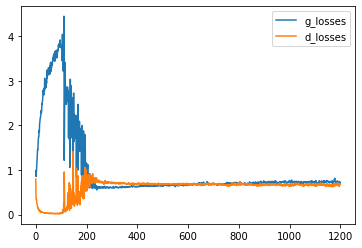

In [14]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

##Check the results

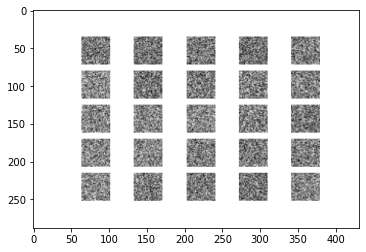

In [15]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

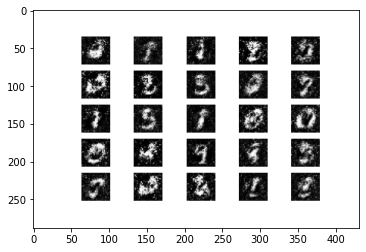

In [16]:
from skimage.io import imread
a = imread('gan_images/1000.png')
plt.imshow(a)